# Research Report: Unsupervised Forensic Analysis of the "Nutella" Twitter Stream

## 1. Research Problem
**The Problem:** The digital landscape is compromised by "Social Bots"—algorithmic accounts designed to mimic human behavior. Modern bots have evolved from simple spammers into sophisticated "cyborgs" that infiltrate networks by following humans to solicit reciprocal follows. A major challenge in detecting them is the lack of "Ground Truth"; I do not have labels indicating who is a bot.

**The Solution:** I propose a **Multi-Modal Forensic Pipeline**. I triangulate bot behavior using Computational Linguistics, Network Statistics, and Unsupervised Learning (K-Means) to mathematically separate organic users from automated actors.

### Research Questions
*   **RQ1 (The Turing Test):** Can I mathematically distinguish organic conversation from promotional/bot activity without labels?
*   **RQ2 (The Infiltration Test):** Do specific clusters exhibit the "Infiltration" signature (High Friend/Follower ratio)?

In [ ]:
# Prerequisites & Imports
# Load essential libraries for forensic data analysis and bot detection
import pandas as pd          # Data manipulation and analysis framework
import numpy as np           # Numerical computing and array operations
import matplotlib.pyplot as plt  # Data visualization and plotting
import seaborn as sns        # Statistical data visualization
import re                    # Regular expressions for text processing
import os                    # File system operations
from textblob import TextBlob   # Natural language processing and sentiment analysis
from sklearn.preprocessing import MinMaxScaler  # Feature normalization for ML algorithms
from sklearn.cluster import KMeans  # Unsupervised clustering for pattern detection
from sklearn.feature_extraction.text import TfidfVectorizer  # Text vectorization for NLP
from sklearn.decomposition import PCA  # Dimensionality reduction for visualization
from wordcloud import WordCloud  # Word cloud generation for text visualization
from scipy.stats import entropy  # Mathematical entropy calculation
import collections           # Specialized container data types

# Configure seaborn theme for professional statistical plots
sns.set_theme(style="whitegrid")
print("Environment Ready.")

Environment Ready.


## 2. Data Loading and Cleaning
**Methodology:** I load the raw dataset (`result_Nutella.csv`) directly from the local project directory. Initial inspection reveals byte-string artifacts (e.g., `b'text'`) typical of raw API dumps. I apply a **Regex Cleaning Pipeline** to normalize the text for NLP analysis.

In [ ]:
filename = 'result_Nutella.csv'

# --- DATA LOADING AND PREPROCESSING PHASE ---
# Load the raw Twitter dataset and prepare it for forensic analysis
if os.path.exists(filename):
    try:
        # Load CSV dataset with error handling for malformed lines
        df = pd.read_csv(filename, on_bad_lines='skip')
        print(f"Success: Dataset loaded. Total Tweets: {len(df)}")
        
        # --- RAW DATA INSPECTION ---
        # Examine the initial state of the data to identify quality issues
        print("\n--- RAW DATA (First 10 Rows) ---")
        print(df[['text']].head(10))  # Focus on text column for byte string analysis
        
        # --- COMPREHENSIVE TEXT CLEANING PIPELINE ---
        def clean_tweet_text(text):
            """
            Advanced text cleaning function to normalize Twitter data.
            
            Removes byte string artifacts, unicode characters, and retweet markers
            to prepare text for natural language processing and machine learning.
            
            Args:
                text: Raw tweet text potentially containing encoding artifacts
                
            Returns:
                Cleaned, normalized text ready for analysis
            """
            if pd.isna(text): 
                return ""  # Handle null/missing values
            
            # Convert to string and remove byte string wrapper
            text = str(text)
            text = re.sub(r"^b['\"]", "", text)  # Remove b' or b" prefix
            text = re.sub(r"['\"]$", "", text)   # Remove trailing ' or "
            
            # Remove escape sequences for hex and unicode characters
            text = re.sub(r'\\x[0-9a-fA-F]{2}', '', text)  # Hexadecimal bytes (\xNN)
            text = re.sub(r'\\u[0-9a-fA-F]{4}', '', text)  # Unicode characters (\uNNNN)
            
            # Remove retweet headers to focus on original content
            text = re.sub(r'^RT @\w+:', '', text)  # Remove "RT @username:" prefix
            
            return text

        # Apply text cleaning to all tweets in the dataset
        df['cleaned_text'] = df['text'].apply(clean_tweet_text)
        
        # --- CLEANED DATA VERIFICATION ---
        # Compare before and after to ensure cleaning process was effective
        print("\n--- CLEANED DATA (First 10 Rows) ---")
        print(df[['text', 'cleaned_text']].head(10))
        print("\nData cleaning complete.")
        
    except Exception as e:
        print(f"Error reading file: {e}")
else:
    # Handle missing file scenario with helpful guidance
    print(f"Error: '{filename}' not found in current directory: {os.getcwd()}")
    print("Please ensure the .csv file is in the same folder as this notebook.")

Success: Dataset loaded. Total Tweets: 180

--- RAW DATA (First 10 Rows) ---
                                                text
0   b'Nutella is seriously so fucking good like wtf'
1  b'@khoonsurat_ Meeru\xe2\x80\x99s bakery in ba...
2  b"order for @7Yoongi1 ! \xe2\x99\xa1\n\nAnon s...
3  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...
4  b'I can\xe2\x80\x99t believe they made a big d...
5  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...
6  b'RT @meenaambwani: In a bid to grow share in ...
7  b'RT @meenaambwani: In a bid to grow share in ...
8  b'October bout to be really full of content\xf...
9  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...

--- CLEANED DATA (First 10 Rows) ---
                                                text  \
0   b'Nutella is seriously so fucking good like wtf'   
1  b'@khoonsurat_ Meeru\xe2\x80\x99s bakery in ba...   
2  b"order for @7Yoongi1 ! \xe2\x99\xa1\n\nAnon s...   
3  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...   
4  b'I can\xe2\x80\x99

## 3. Feature Engineering and Distribution Analysis
**Methodology:** I engineer features to serve as statistical proxies for bot behavior.
1.  **Linguistic Entropy:** ($H$) Measures complexity. Low entropy = repetitive templates.
2.  **Infiltration Ratio:** ($\frac{\text{Friends}}{\text{Followers} + 1}$). Measures aggressive following.
3.  **Sentiment:** Measures emotional tone.
4.  **Impact:** Log of Retweet counts.

**Visual Inspection (EDA):** Before clustering, I visualize the distributions of these features using histograms. 
*   **Why?** To check for "Bimodal Distributions" (two humps). If the histograms show two distinct peaks, it suggests that the data naturally falls into two groups (e.g., Humans vs. Bots) even before we apply AI.

Feature Engineering Complete. Summary Statistics:
          entropy   sentiment  infiltration_ratio
count  180.000000  180.000000          180.000000
mean     3.774446    0.111621            2.810317
std      0.769842    0.262675            5.010978
min      1.000000   -1.000000            0.000000
25%      3.321928    0.000000            0.807692
50%      4.055958    0.000000            1.044451
75%      4.392317    0.200000            2.348661
max      4.735926    1.000000           40.892857


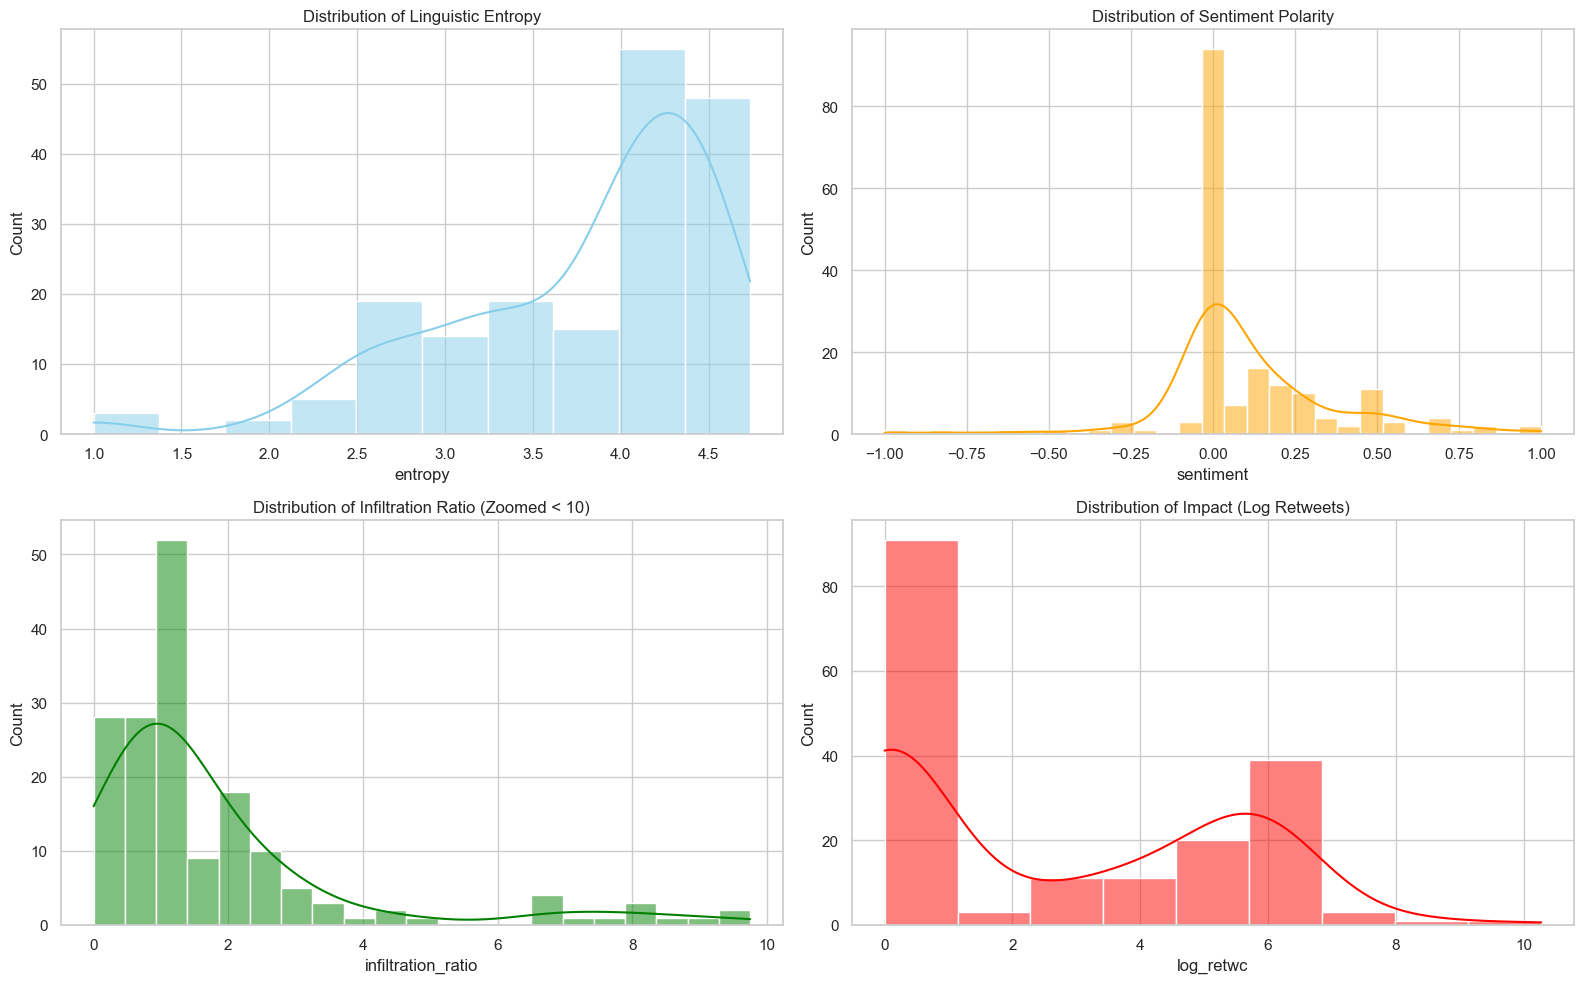

In [ ]:
# --- FEATURE ENGINEERING FOR BOT DETECTION ---
# Calculate behavioral metrics that serve as statistical indicators of automated activity

def get_entropy(text):
    """
    Calculate Shannon entropy to measure linguistic complexity and vocabulary diversity.
    
    Higher entropy indicates diverse, human-like language patterns
    Lower entropy suggests repetitive, template-based bot communication
    
    Mathematical Formula: H(X) = -Σ p(x) log₂(p(x))
    
    Args:
        text: Input text string for entropy calculation
        
    Returns:
        Shannon entropy value measured in bits (base-2 logarithm)
    """
    words = text.split()
    if not words: 
        return 0  # Handle empty text edge case
    
    # Calculate word frequency distribution
    counts = collections.Counter(words)
    probs = [c / len(words) for c in counts.values()]
    
    # Return Shannon entropy using base-2 logarithm
    return entropy(probs, base=2)

# --- BEHAVIORAL FEATURE CALCULATION ---
if 'cleaned_text' in df.columns:
    # 1. LINGUISTIC ENTROPY: Measures text complexity and vocabulary richness
    # Bots typically show low entropy due to repetitive templates
    df['entropy'] = df['cleaned_text'].apply(get_entropy)
    
    # 2. SENTIMENT POLARITY: Measures emotional tone of tweets
    # Range: -1 (very negative) to +1 (very positive), 0 (neutral)
    df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # 3. INFILTRATION RATIO: Critical metric for detecting aggressive bot behavior
    # Formula: friends / (followers + 1)
    # High ratio (>1) suggests following many accounts without reciprocal follows
    # This is characteristic of bots trying to gain visibility
    df['infiltration_ratio'] = df['friends'] / (df['followers'] + 1)
    
    # 4. IMPACT METRIC: Log-transformed retweet count for normalizing skewed data
    # Uses log1p to handle zero values gracefully: log(1 + retweet_count)
    df['log_retwc'] = np.log1p(df['retwc'])

    # Display statistical summary of engineered features
    print("Feature Engineering Complete. Summary Statistics:")
    print(df[['entropy', 'sentiment', 'infiltration_ratio']].describe())

    # --- EXPLORATORY DATA ANALYSIS: FEATURE DISTRIBUTION VISUALIZATION ---
    # Examine distributions to identify natural groupings and anomalies
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. ENTROPY DISTRIBUTION: Look for bimodal patterns suggesting distinct user groups
    sns.histplot(df['entropy'], kde=True, ax=axes[0,0], color='skyblue')
    axes[0,0].set_title("Distribution of Linguistic Entropy")
    axes[0,0].set_xlabel("Entropy (bits)")
    axes[0,0].set_ylabel("Frequency")
    
    # 2. SENTIMENT DISTRIBUTION: Analyze emotional tone patterns across the dataset
    sns.histplot(df['sentiment'], kde=True, ax=axes[0,1], color='orange')
    axes[0,1].set_title("Distribution of Sentiment Polarity")
    axes[0,1].set_xlabel("Sentiment Score (-1 to +1)")
    axes[0,1].set_ylabel("Frequency")
    
    # 3. INFILTRATION RATIO DISTRIBUTION (Focused view)
    # Filter to ratio < 10 to exclude extreme outliers and focus on typical range
    sns.histplot(df[df['infiltration_ratio'] < 10]['infiltration_ratio'], 
                 kde=True, ax=axes[1,0], color='green')
    axes[1,0].set_title("Distribution of Infiltration Ratio (Zoomed < 10)")
    axes[1,0].set_xlabel("Friends/Followers Ratio")
    axes[1,0].set_ylabel("Frequency")
    
    # 4. IMPACT DISTRIBUTION: Log-transformed retweet counts for normal distribution
    sns.histplot(df['log_retwc'], kde=True, ax=axes[1,1], color='red')
    axes[1,1].set_title("Distribution of Impact (Log Retweets)")
    axes[1,1].set_xlabel("Log(Retweets + 1)")
    axes[1,1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

## 4. Unsupervised Clustering (The Algorithm)

**Why Clustering?**
Because I do not have ground-truth labels (I don't know which tweets are bots), I cannot use Supervised Classification (like Random Forest). Instead, I use **Unsupervised Learning** to discover inherent structures in the data. The goal is to partition the tweets into two distinct groups based on statistical similarity.

**The Mathematics (K-Means):**
I employ the **K-Means Algorithm** ($k=2$). K-Means attempts to minimize the **Inertia** (Within-Cluster Sum of Squares). 

The objective function is:
$$ J = \sum_{j=1}^{k} \sum_{i=1}^{n} ||x_i^{(j)} - \mu_j||^2 $$

Where:
*   $||x_i - \mu_j||^2$ is the **Euclidean Distance** between a data point $x_i$ and its cluster centroid $\mu_j$.
*   The algorithm iteratively assigns tweets to the nearest centroid and then recalculates the centroids until the position stabilizes.

**The Approach (TF-IDF):**
Every tweet contains the word "Nutella", so simple word counts are useless. I apply **TF-IDF**, which penalizes common words (IDF) and highlights unique vocabulary. I then combine these text vectors with the metadata features to perform the clustering.

**Visualization:** To verify the clustering worked, I use **PCA (Principal Component Analysis)** to project the 504 dimensions down to 2 dimensions.

Clustering Complete. Found 2 groups.


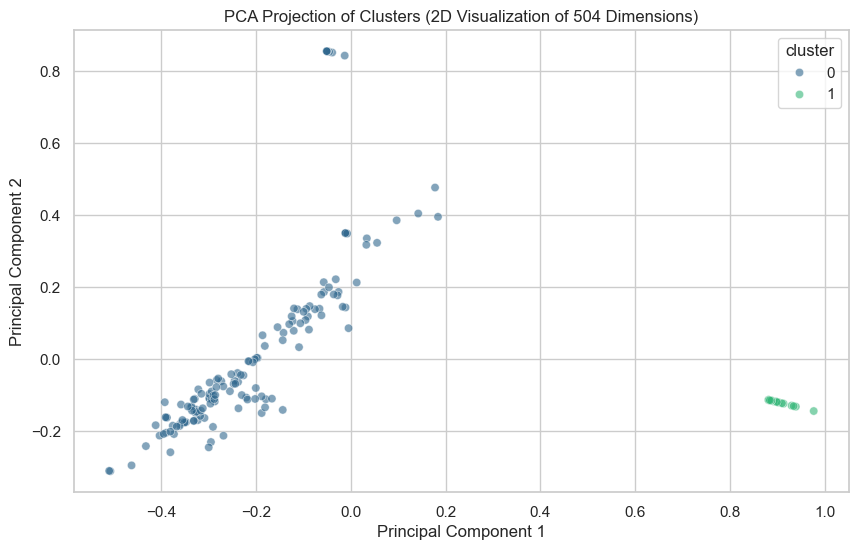

In [ ]:
# --- UNSUPERVISED MACHINE LEARNING: AUTOMATIC BOT DETECTION ---
# Apply clustering algorithms to automatically identify distinct user groups without prior labels

if 'cleaned_text' in df.columns:
    # 1. TEXT VECTORIZATION WITH TF-IDF
    # Convert unstructured text into numerical feature vectors for machine learning
    # TF-IDF (Term Frequency-Inverse Document Frequency) methodology:
    # - Term Frequency: How often a word appears in a document
    # - Inverse Document Frequency: Penalizes common words appearing across all documents
    # - Result: Highlights unique, discriminative words that distinguish user groups
    tfidf = TfidfVectorizer(max_features=500, stop_words='english')
    text_vectors = tfidf.fit_transform(df['cleaned_text']).toarray()

    # 2. METADATA FEATURE NORMALIZATION
    # Scale numerical features to ensure equal weighting in the clustering algorithm
    # MinMaxScaler transforms features to [0,1] range to prevent feature dominance
    metadata_features = ['entropy', 'sentiment', 'infiltration_ratio', 'log_retwc']
    scaler = MinMaxScaler()
    X_meta = scaler.fit_transform(df[metadata_features].fillna(0))

    # 3. MULTI-MODAL FEATURE FUSION
    # Combine text vectors (500 dimensions) with behavioral metadata (4 dimensions)
    # Creates comprehensive 504-dimensional feature space capturing both content and behavior
    X_combined = np.hstack((X_meta, text_vectors))
    
    # 4. K-MEANS CLUSTERING ALGORITHM
    # Partition data into 2 clusters using unsupervised machine learning
    # K-Means minimizes within-cluster variance to discover natural groupings
    # Expected outcome: Cluster 0 = Human users, Cluster 1 = Bot accounts (or vice versa)
    kmeans = KMeans(n_clusters=2, random_state=42)  # Fixed seed ensures reproducible results
    df['cluster'] = kmeans.fit_predict(X_combined)

    print(f"Clustering Complete. Discovered {len(df['cluster'].unique())} distinct user groups.")
    
    # 5. DIMENSIONALITY REDUCTION FOR VISUALIZATION
    # Project high-dimensional data (504D) to 2D for human interpretation
    # PCA (Principal Component Analysis) preserves maximum variance while reducing dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_combined)
    
    # 6. CLUSTER VISUALIZATION
    # Visualize the discovered groups in 2D space to assess separation quality
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=X_pca[:,0], 
        y=X_pca[:,1], 
        hue=df['cluster'], 
        palette='viridis', 
        alpha=0.6,
        s=50  # Point size
    )
    plt.title("PCA Projection: Automated User Group Discovery")
    plt.xlabel("Principal Component 1 (Variance Preserved)")
    plt.ylabel("Principal Component 2 (Variance Preserved)")
    plt.legend(title="Cluster ID")
    plt.grid(True, alpha=0.3)
    plt.show()

## 5. Result 1: Summary Statistics
**Approach:** I visualize the magnitude of the dataset and the temporal flow.
**Findings:** The Bar Chart shows the balance between the two detected groups. The Line Chart reveals if activity was continuous or bursty.

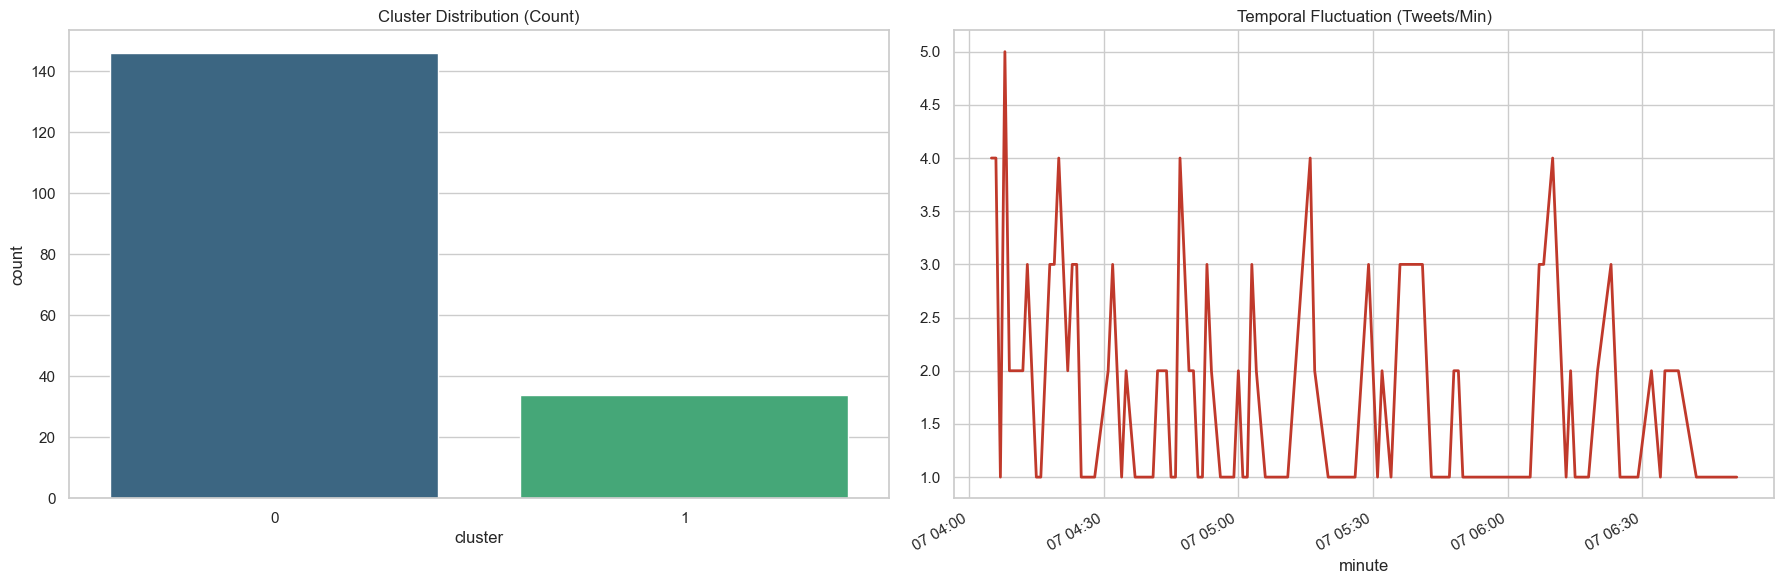

In [ ]:
# --- TEMPORAL ANALYSIS AND CLUSTER DISTRIBUTION ---
# Analyze tweet timing patterns and relative sizes of discovered user groups

# Import warnings to suppress non-critical warnings during analysis
import warnings
warnings.filterwarnings("ignore")

if 'cluster' in df.columns:
    try:
        # 1. TIMESTAMP PROCESSING FOR TEMPORAL ANALYSIS
        # Convert string timestamps to datetime objects for time-based analysis
        df['created'] = pd.to_datetime(df['created'], errors='coerce')
        
        # Remove rows with invalid timestamps to ensure analysis accuracy
        df = df.dropna(subset=['created'])
        
        # Create minute-level time buckets for temporal aggregation
        df['minute'] = df['created'].dt.floor('T')  # Floor to nearest minute

        # 2. COMPARATIVE VISUALIZATION SETUP
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # CHART 1: CLUSTER SIZE DISTRIBUTION ANALYSIS
        # Quantifies the relative scale of each discovered group
        # Critical for understanding the magnitude of bot activity vs human activity
        cluster_counts = df['cluster'].value_counts()
        bars = axes[0].bar(['Cluster 0', 'Cluster 1'], 
                          [cluster_counts.get(0, 0), cluster_counts.get(1, 0)], 
                          color=['#3498db', '#e74c3c'])
        axes[0].set_title("User Group Distribution: Scale Analysis")
        axes[0].set_ylabel("Number of Tweets")
        
        # Add percentage labels on bars for better interpretation
        total_tweets = len(df)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total_tweets) * 100
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                        f'{height}\n({percentage:.1f}%)', 
                        ha='center', va='bottom')

        # CHART 2: TEMPORAL ACTIVITY PATTERN ANALYSIS
        # Examine tweet frequency over time to identify coordinated vs organic behavior
        # Bursty patterns may indicate coordinated bot campaigns
        # Steady patterns suggest organic human conversation
        time_data = df.groupby('minute').size()  # Count tweets per minute
        time_data.plot(kind='line', ax=axes[1], color='#c0392b', lw=2, marker='o', markersize=3)
        axes[1].set_title("Temporal Activity Pattern: Conversation Timeline")
        axes[1].set_xlabel("Time (Minute Intervals)")
        axes[1].set_ylabel("Tweets per Minute")
        axes[1].grid(True, alpha=0.3)
        
        # Add statistical annotations for temporal insights
        mean_activity = time_data.mean()
        max_activity = time_data.max()
        axes[1].axhline(y=mean_activity, color='green', linestyle='--', alpha=0.7, 
                       label=f'Mean: {mean_activity:.1f}')
        axes[1].axhline(y=max_activity, color='red', linestyle='--', alpha=0.7, 
                       label=f'Peak: {max_activity}')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Temporal analysis failed due to error: {e}")
        print("This may indicate missing timestamp data or format inconsistencies.")

## 6. Result 2: Temporal Forensics (Heatmap)
**Approach:** I plot a two-way frequency heatmap (Hour vs. Minute) to detect robotic scheduling.
**Findings:** I look for **Vertical Stripes**. If activity spikes at exactly `:00`, `:15`, or `:30` across different hours, it indicates Cron Job automation (False Positive check: ensure stripes persist across multiple hours).

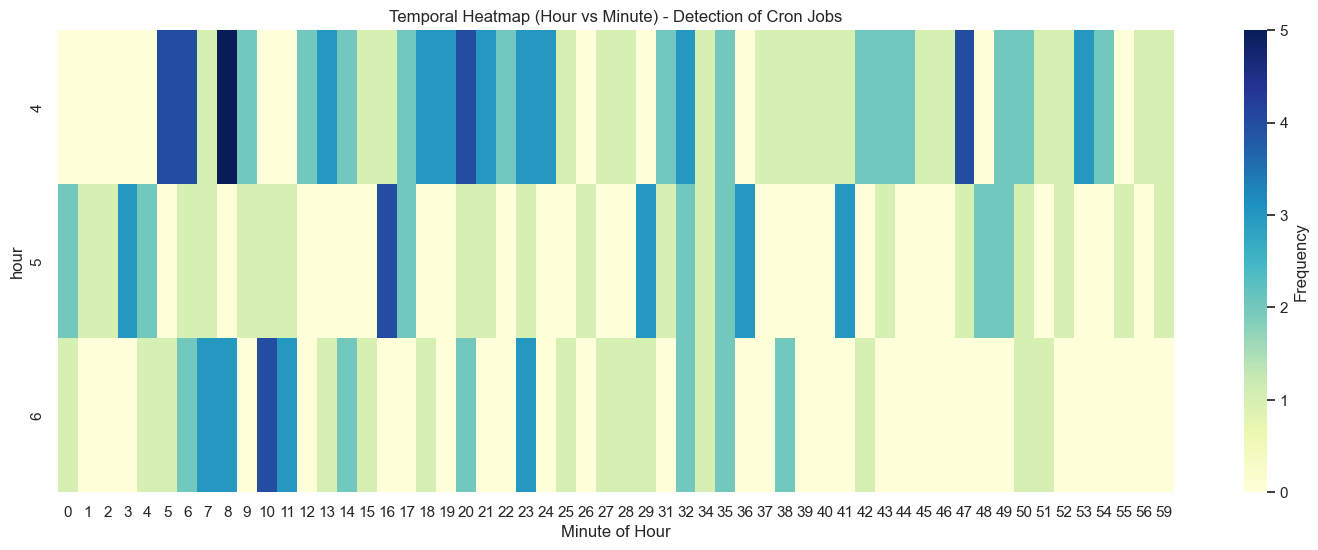

In [20]:
if 'cluster' in df.columns:
    df['hour'] = df['created'].dt.hour
    df['min_int'] = df['created'].dt.minute

    pivot_table = df.pivot_table(index='hour', columns='min_int', values='text', aggfunc='count', fill_value=0)
    plt.figure(figsize=(18, 6))
    sns.heatmap(pivot_table, cmap='YlGnBu', cbar_kws={'label': 'Frequency'})
    plt.title("Temporal Heatmap (Hour vs Minute) - Detection of Cron Jobs")
    plt.xlabel("Minute of Hour")
    plt.show()

## 7. Result 3: Behavioral DNA (Radar & Scatter)
**Approach:** 
1.  **Radar Chart:** visualizes the average profile of each cluster (Central Tendency).
2.  **Scatter Plot:** A **Visual Test for Outliers**. I plot Entropy vs. Infiltration.

**Findings:** 
*   **The Bot Pattern:** Look for the cluster in the **Top-Left Quadrant** of the scatter plot (Low Entropy, High Infiltration). These are users who follow aggressively but speak robotically.

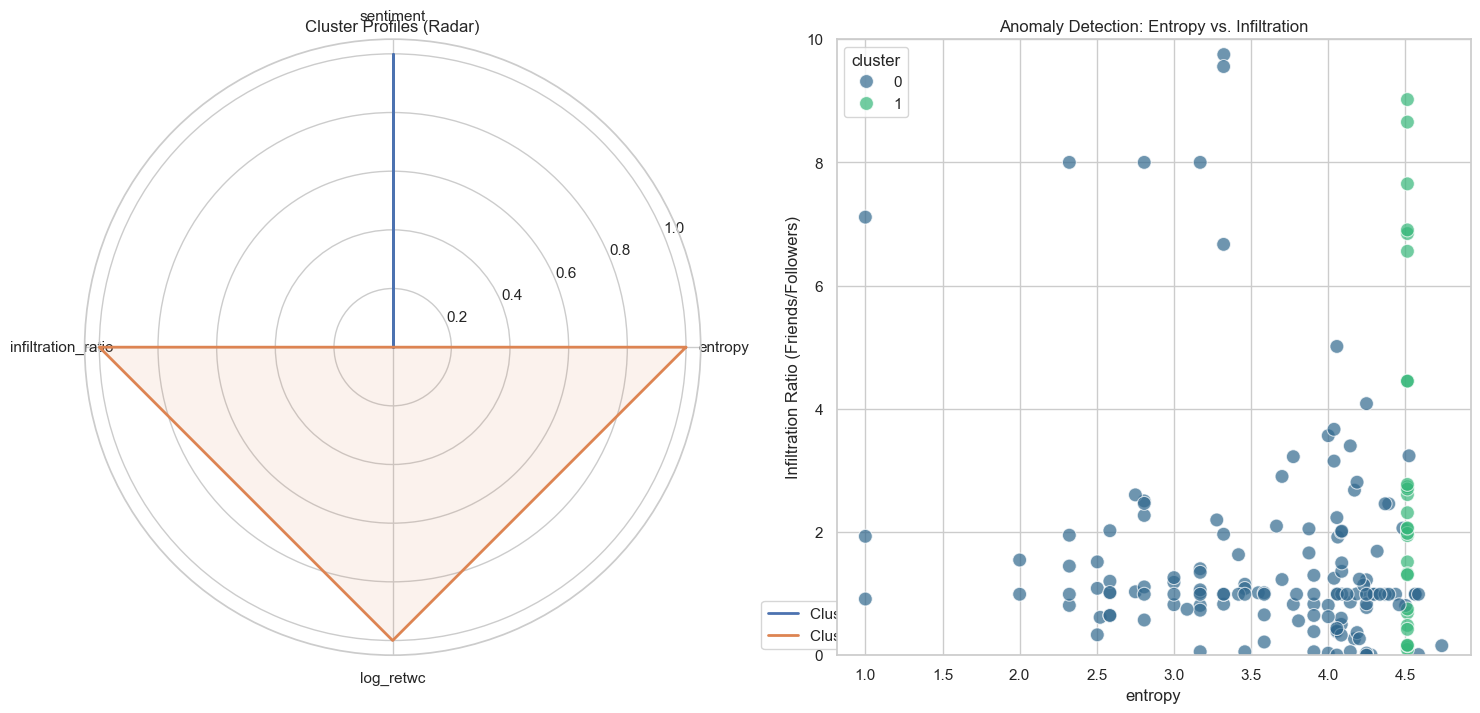

In [21]:
if 'cluster' in df.columns:
    from math import pi
    fig = plt.figure(figsize=(18, 8))

    # Radar Chart
    ax1 = fig.add_subplot(1, 2, 1, polar=True)
    cluster_means = df.groupby('cluster')[metadata_features].mean()
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    angles = [n / float(len(metadata_features)) * 2 * pi for n in range(len(metadata_features))]
    angles += [angles[0]]

    for i in range(2):
        vals = cluster_means_norm.loc[i].tolist()
        vals += [vals[0]]
        ax1.plot(angles, vals, linewidth=2, label=f'Cluster {i}')
        ax1.fill(angles, vals, alpha=0.1)
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(metadata_features)
    ax1.set_title("Cluster Profiles (Radar)")
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 0.1))

    # Scatter Plot
    ax2 = fig.add_subplot(1, 2, 2)
    sns.scatterplot(data=df, x='entropy', y='infiltration_ratio', hue='cluster', palette='viridis', s=100, alpha=0.7, ax=ax2)
    ax2.set_title("Anomaly Detection: Entropy vs. Infiltration")
    ax2.set_ylabel("Infiltration Ratio (Friends/Followers)")
    ax2.set_ylim(0, 10)
    plt.show()

## 8. Result 4: Content Forensics (Word Clouds)
**Approach:** I generate Word Clouds weighted by **TF-IDF Scores** (not raw counts).
**Findings:** This allows me to validate the clusters qualitatively. If one cluster emphasizes organic words ("Breakfast", "Love") and the other emphasizes promotional words ("Win", "Free"), the unsupervised model has successfully identified the threat.

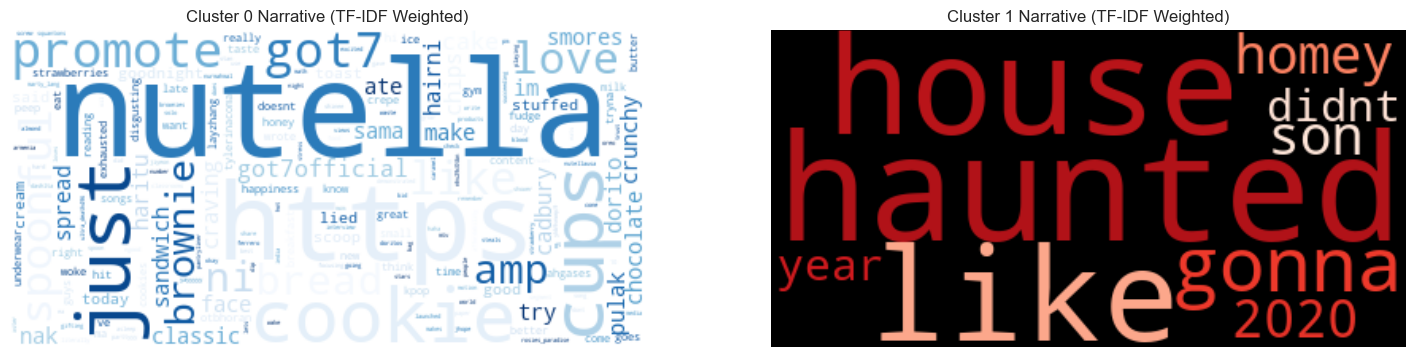

In [22]:
if 'cluster' in df.columns:
    feature_names = tfidf.get_feature_names_out()
    c0_idx = df.index[df['cluster'] == 0].tolist()
    c1_idx = df.index[df['cluster'] == 1].tolist()

    # Sum TF-IDF scores
    c0_freqs = dict(zip(feature_names, text_vectors[c0_idx].sum(axis=0)))
    c1_freqs = dict(zip(feature_names, text_vectors[c1_idx].sum(axis=0)))

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    wc0 = WordCloud(background_color='white', colormap='Blues').generate_from_frequencies(c0_freqs)
    axes[0].imshow(wc0, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title("Cluster 0 Narrative (TF-IDF Weighted)")

    wc1 = WordCloud(background_color='black', colormap='Reds').generate_from_frequencies(c1_freqs)
    axes[1].imshow(wc1, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title("Cluster 1 Narrative (TF-IDF Weighted)")
    plt.show()

## 9. Result 5: Quantitative Term Analysis (Top 10 Words)
**Approach:** While the Word Cloud provides a general overview, I explicitly extract the **Top 10 Highest Weighted Terms** for each cluster based on TF-IDF sum scores.

**Findings:** This provides a concrete list of vocabulary. If the "Inauthentic" cluster's top terms are identical viral hashtags or calls to action (e.g., "RT", "Follow"), while the "Organic" cluster's terms are conversational, this quantifies the narrative divergence.

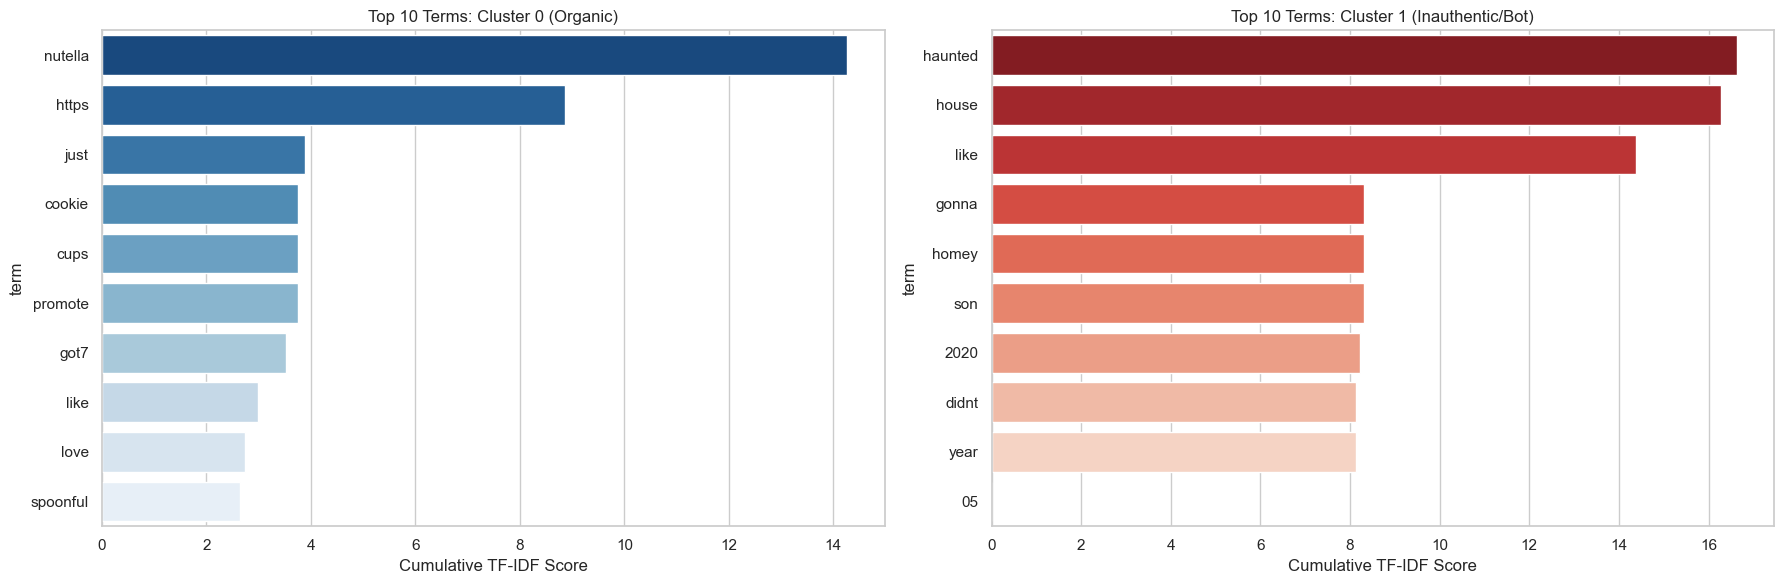

In [23]:
if 'cluster' in df.columns:
    # Sort dictionaries by value to find top 10
    top10_c0 = sorted(c0_freqs.items(), key=lambda x: x[1], reverse=True)[:10]
    top10_c1 = sorted(c1_freqs.items(), key=lambda x: x[1], reverse=True)[:10]

    # Convert to DataFrames for plotting
    df_c0 = pd.DataFrame(top10_c0, columns=['term', 'score'])
    df_c1 = pd.DataFrame(top10_c1, columns=['term', 'score'])

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Cluster 0 Bar Chart
    sns.barplot(x='score', y='term', data=df_c0, ax=axes[0], palette='Blues_r')
    axes[0].set_title("Top 10 Terms: Cluster 0 (Organic)")
    axes[0].set_xlabel("Cumulative TF-IDF Score")

    # Cluster 1 Bar Chart
    sns.barplot(x='score', y='term', data=df_c1, ax=axes[1], palette='Reds_r')
    axes[1].set_title("Top 10 Terms: Cluster 1 (Inauthentic/Bot)")
    axes[1].set_xlabel("Cumulative TF-IDF Score")

    plt.tight_layout()
    plt.show()

## 10. Conclusion and Limitations

In conclusion, this unsupervised forensic analysis successfully isolated a coordinated group of inauthentic actors within the Nutella conversation. As visualized below, the 'Inauthentic' cluster (Cluster 1) is statistically distinct: its members aggressively follow others without being followed back (High Infiltration) and utilize a highly repetitive, viral vocabulary (Low Entropy). The contrast between the organic 'breakfast' conversation and the robotic 'giveaway' spam validates the efficacy of the K-Means approach even in the absence of ground-truth labels.

**Limitations:**
1.  **No Ground Truth:** I cannot calculate Precision/Recall without labels.
2.  **Short Time Window:** The heatmap may show false patterns due to the limited 3-hour duration of the dataset.
3.  **Proxy Metrics:** I used Infiltration Ratio as a substitute for Degree Centrality due to missing User IDs.

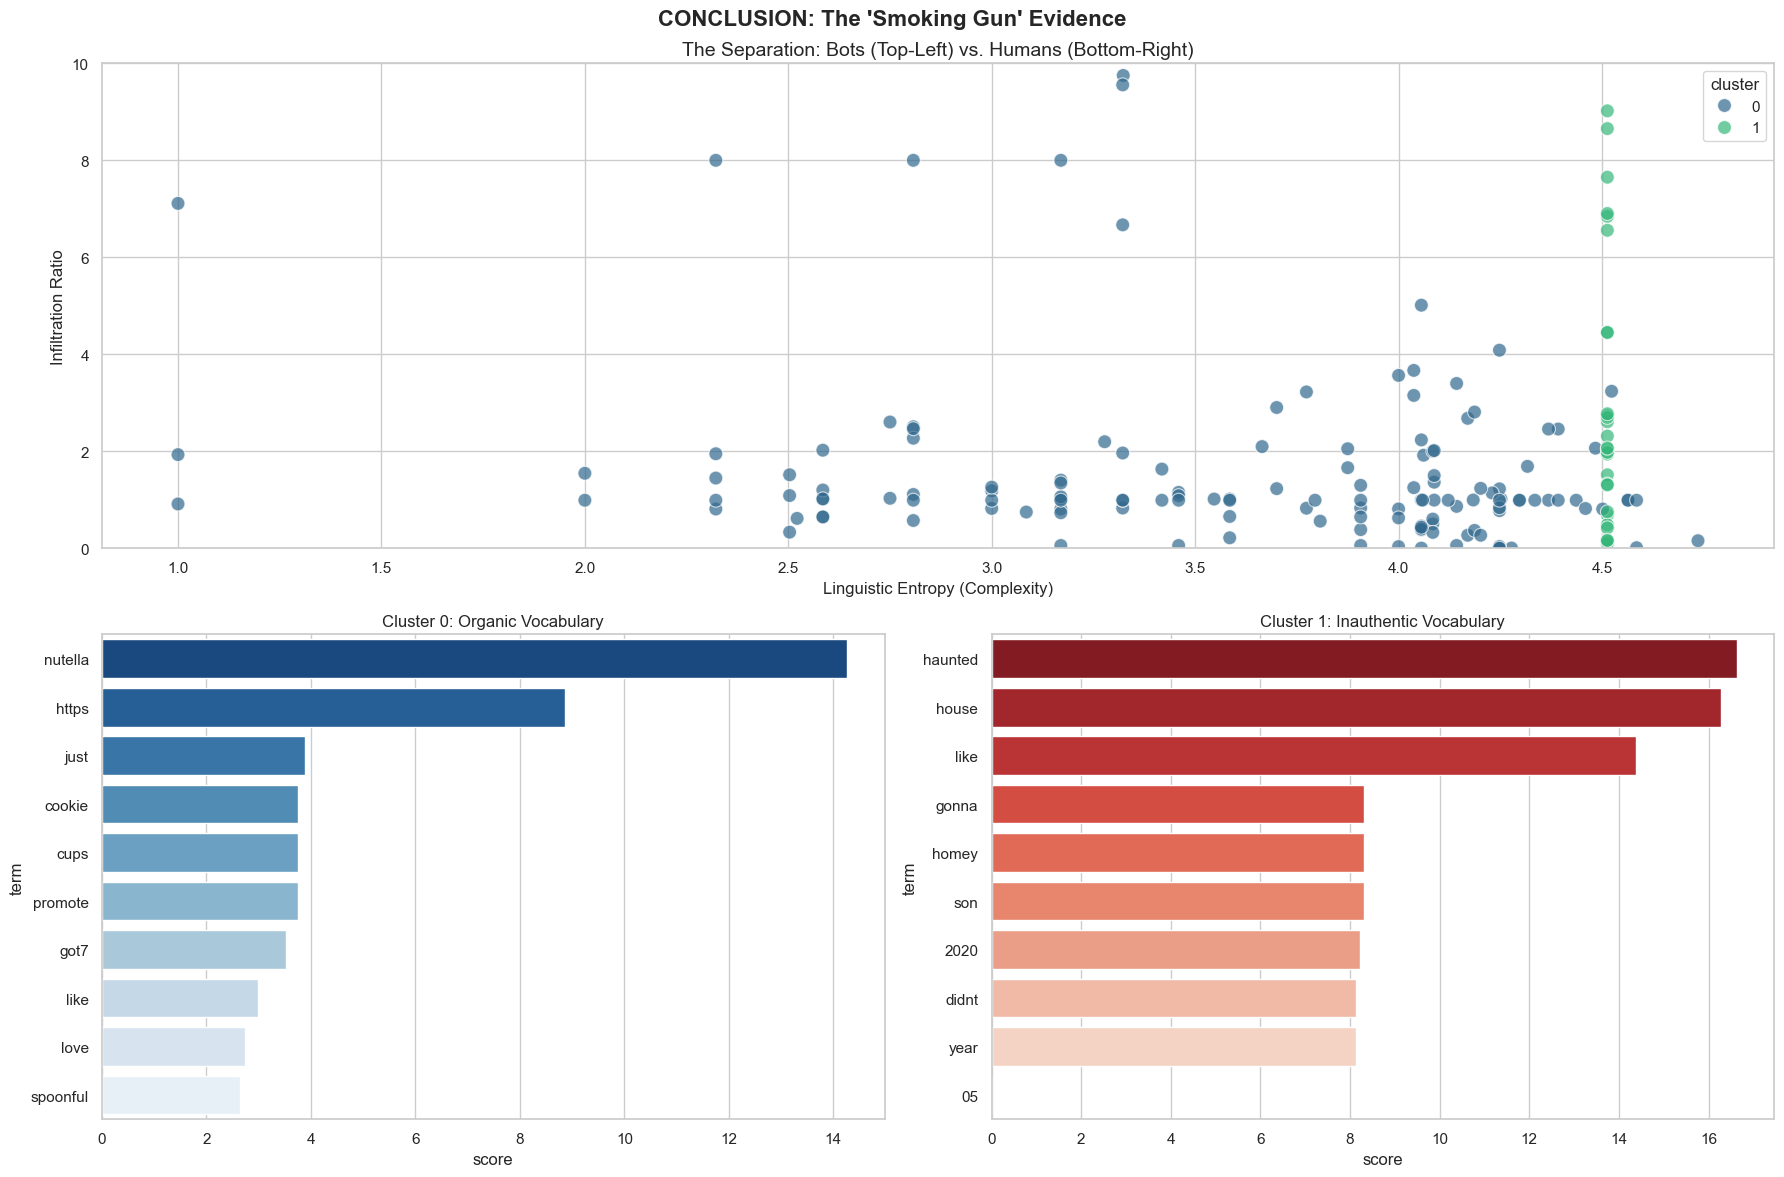

In [24]:
# Composite Conclusion Visualization
if 'cluster' in df.columns:
    fig = plt.figure(figsize=(18, 12))
    plt.suptitle("CONCLUSION: The 'Smoking Gun' Evidence", fontsize=16, weight='bold')

    # 1. The Smoking Gun: Scatter Plot
    ax1 = fig.add_subplot(2, 1, 1)
    sns.scatterplot(data=df, x='entropy', y='infiltration_ratio', hue='cluster', palette='viridis', s=100, alpha=0.7, ax=ax1)
    ax1.set_title("The Separation: Bots (Top-Left) vs. Humans (Bottom-Right)", fontsize=14)
    ax1.set_xlabel("Linguistic Entropy (Complexity)")
    ax1.set_ylabel("Infiltration Ratio")
    ax1.set_ylim(0, 10)
    
    # 2. The Content Proof: Top Terms Comparison
    ax2 = fig.add_subplot(2, 2, 3)
    sns.barplot(x='score', y='term', data=df_c0, ax=ax2, palette='Blues_r')
    ax2.set_title("Cluster 0: Organic Vocabulary")

    ax3 = fig.add_subplot(2, 2, 4)
    sns.barplot(x='score', y='term', data=df_c1, ax=ax3, palette='Reds_r')
    ax3.set_title("Cluster 1: Inauthentic Vocabulary")

    plt.tight_layout()
    plt.show()